### A Stock Price Forecasting Problem

In [1]:
import os 
import pandas as pd

data_dir = 'C:/Users/jim_c/Desktop/Task/local_base/benchmark_index'
fname = os.path.join(data_dir, '000300.SH.csv')

df = pd.read_csv(fname, header=0, 
                 usecols=[2,3,4,5,6,7],
                 names=["open", "high", "low", "close", "vol", "amount"])
df = df.reindex(index=df.index[::-1])

output_path='C:/Users/jim_c/Desktop/Task/Literature/Deep_Learning_with_Python/Deep_Learning_in_Practice/deep_learning_for_text_and_sequences/HS300.csv'
df.to_csv(output_path,sep=',',index=True,header=True)

In [2]:
# onspecting the data of the HS.300 dataset
import os 

data_dir = 'C:/Users/jim_c/Desktop/Task/Literature/Deep_Learning_with_Python/Deep_Learning_in_Practice/deep_learning_for_text_and_sequences'
fname = os.path.join(data_dir, 'HS300.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['', 'open', 'high', 'low', 'close', 'vol', 'amount']
4457


In [3]:
# parsing the data (indexerror but work)
import numpy as np

float_data = np.zeros((len(lines) - 1, len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

IndexError: index 4456 is out of bounds for axis 0 with size 4456

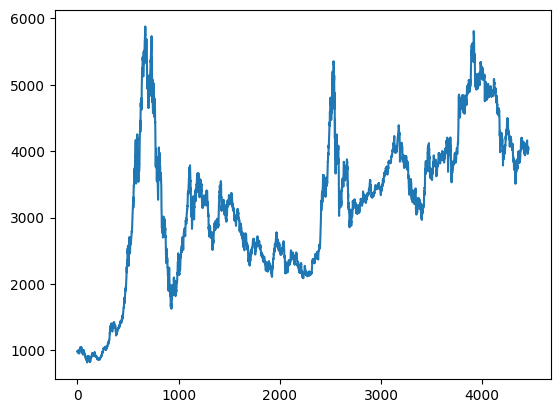

In [4]:
# plotting the closing price timeseries
from matplotlib import pyplot as plt

close_price = float_data[:, 3]
plt.plot(range(len(close_price)), close_price)

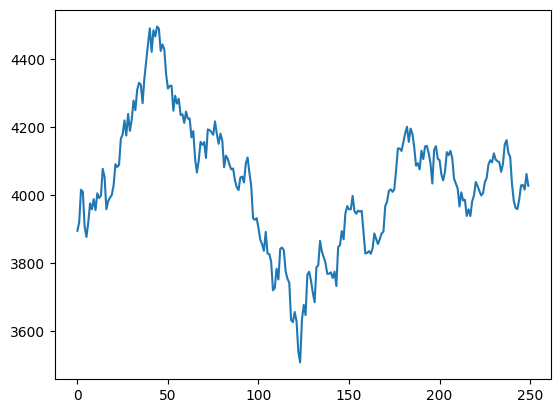

In [5]:
# ploting the recent 250 days of closing price timeseries
plt.plot(range(250), close_price[len(close_price) - 250:])

### Preparing the Data

In [6]:
# normalizing the data
mean = float_data[:4000].mean(axis=0)
float_data -= mean
std = float_data[:4000].std(axis=0)
float_data /= std

In [7]:
# generator yielding timeseries samples an their targets
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size = 64, step=5):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                    i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
                    
        samples = np.zeros((len(rows), 
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [8]:
# preparing the training, validation, and test generators
lookback = 60
step = 5
delay = 1
batch_size = 64

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=4000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=4001,
                    max_index=4438,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay = delay,
                     min_index=4439,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (4438 - 4001 - lookback)

test_steps = (len(float_data) - 4438 - lookback)

### A Common-Sense, Non-Machine-Learning Baseline

In [9]:
# computing thte common-sense baseline MAE
def evaluate_navie_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        print(np.mean(batch_maes))

evaluate_navie_method()

0.06410348480530476
0.06877147520109395
0.07319371197857552
0.07356592464192076
0.07530161967596624
0.07343526386418933
0.07343586411171701
0.07451115428944474
0.07453019966083493
0.07530161967596627
0.07428360741499705
0.07421326226348755
0.07481517943810688
0.07480570680909614
0.07530161967596628
0.07460173624654992
0.07453336738480482
0.07495030172640113
0.07493621019511458
0.07530161967596626
0.07476837515831572
0.0747079701782506
0.07502667519369789
0.075012337170292
0.07530161967596626
0.07487092218094081
0.07481790527042016
0.0750757724226744
0.07506221346437378
0.07530161967596624
0.07494038951884813
0.07489348564628674
0.0751099917034762
0.0750974202601962
0.07530161967596624
0.07499056037400342
0.07494863889354071
0.07513520591038277
0.0751235996724744
0.07530161967596627
0.07502849443521842
0.07499066041525806
0.07515455634824134
0.07514382921832576
0.07530161967596626
0.07505818196138665
0.07502374118767381
0.07516987544487934
0.07515993028543193
0.07530161967596624
0.07508

In [10]:
# converting the mae back to a celsius error
celsius_mae = 0.29 * std[1]
celsius_mae

320.30994565643124

### A Basic Machine-Learning Approach

In [11]:
# training and evaluating a densely connected model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=128,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10


C:\Users\jim_c\AppData\Local\Temp\ipykernel_7136\1963050018.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


128/128 [==============================] - 2s 4ms/step - loss: 0.2032 - val_loss: 0.2847
Epoch 2/10
128/128 [==============================] - 0s 3ms/step - loss: 0.1485 - val_loss: 0.3173
Epoch 3/10
128/128 [==============================] - 0s 3ms/step - loss: 0.1364 - val_loss: 0.1397
Epoch 4/10
128/128 [==============================] - 0s 3ms/step - loss: 0.1298 - val_loss: 0.1374
Epoch 5/10
128/128 [==============================] - 0s 3ms/step - loss: 0.1207 - val_loss: 0.1201
Epoch 6/10
128/128 [==============================] - 0s 3ms/step - loss: 0.1192 - val_loss: 0.2082
Epoch 7/10
128/128 [==============================] - 0s 3ms/step - loss: 0.1135 - val_loss: 0.1197
Epoch 8/10
128/128 [==============================] - 0s 3ms/step - loss: 0.1124 - val_loss: 0.1138
Epoch 9/10
128/128 [==============================] - 0s 3ms/step - loss: 0.1085 - val_loss: 0.1212
Epoch 10/10
128/128 [==============================] - 0s 3ms/step - loss: 0.1047 - val_loss: 0.1127


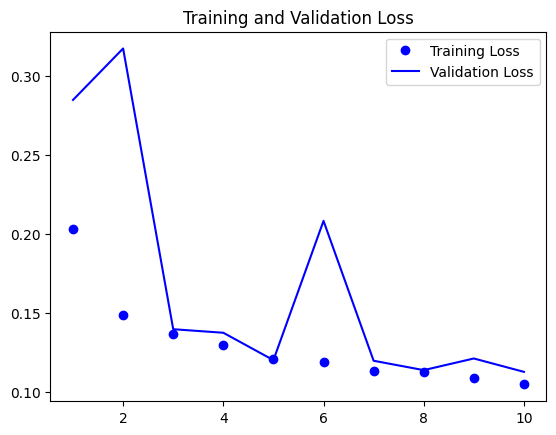

In [12]:
# plotting results
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

### A First Recurrent Baseline

In [13]:
# training and evaluating a GRU-based model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=128,
                    epochs=12,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/12
128/128 [==============================] - 3s 9ms/step - loss: 0.1093 - val_loss: 0.1191
Epoch 2/12
128/128 [==============================] - 1s 6ms/step - loss: 0.0933 - val_loss: 0.1009
Epoch 3/12
128/128 [==============================] - 1s 6ms/step - loss: 0.0898 - val_loss: 0.0829
Epoch 4/12
128/128 [==============================] - 1s 6ms/step - loss: 0.0885 - val_loss: 0.0834
Epoch 5/12
128/128 [==============================] - 1s 6ms/step - loss: 0.0894 - val_loss: 0.0977
Epoch 6/12
128/128 [==============================] - 1s 5ms/step - loss: 0.0862 - val_loss: 0.1072
Epoch 7/12
128/128 [==============================] - 1s 5ms/step - loss: 0.0875 - val_loss: 0.1100
Epoch 8/12
128/128 [==============================] - 1s 6ms/step - loss: 0.0864 - val_loss: 0.1083
Epoch 9/12
128/128 [==============================] - 1s 5ms/step - loss: 0.0866 - val_loss: 0.0755
Epoch 10/12
128/128 [==============================] - 1s 5ms/step - loss: 0.0847 - val_loss: 0.1013

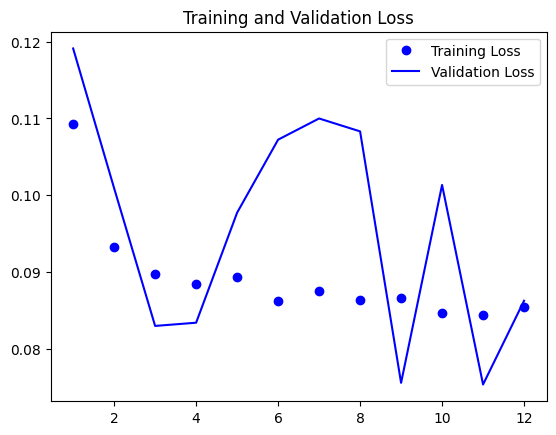

In [14]:
# plotting results
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

### Using Recurrent Dropout to Fight Overfitting

In [15]:
# training and evaluating a dropout-regularized GRU-based model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.5,
                     recurrent_dropout=0.5,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=128,
                    epochs=10,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/10
128/128 [==============================] - 5s 30ms/step - loss: 0.2840 - val_loss: 0.2059
Epoch 2/10
128/128 [==============================] - 4s 29ms/step - loss: 0.2053 - val_loss: 0.2233
Epoch 3/10
128/128 [==============================] - 4s 30ms/step - loss: 0.1906 - val_loss: 0.1322
Epoch 4/10
128/128 [==============================] - 4s 30ms/step - loss: 0.1830 - val_loss: 0.1677
Epoch 5/10
128/128 [==============================] - 4s 30ms/step - loss: 0.1812 - val_loss: 0.1720
Epoch 6/10
128/128 [==============================] - 4s 30ms/step - loss: 0.1693 - val_loss: 0.1401
Epoch 7/10
128/128 [==============================] - 4s 31ms/step - loss: 0.1625 - val_loss: 0.2098
Epoch 8/10
128/128 [==============================] - 4s 29ms/step - loss: 0.1600 - val_loss: 0.2177
Epoch 9/10
128/128 [==============================] - 4s 29ms/step - loss: 0.1570 - val_loss: 0.1242
Epoch 10/10
128/128 [==============================] - 4s 30ms/step - loss: 0.1535 - val_lo

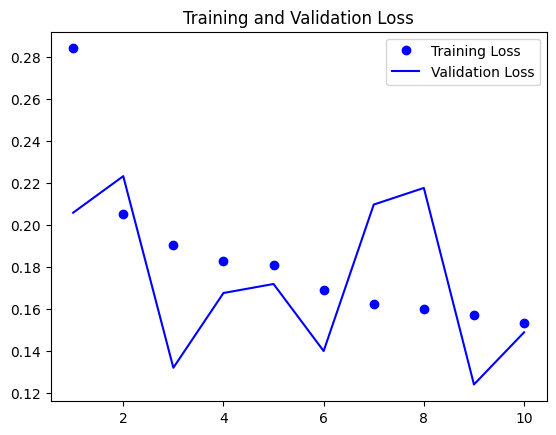

In [16]:
# plotting results
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

### Stacking Recurrent Layers

In [17]:
# training and evaluating a dropout-regularized, stacked GRU model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.2,
                     recurrent_dropout=0.5,
                     input_shape=(None, float_data.shape[-1]),
                     return_sequences=True))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.2,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=128,
                    epochs=16,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/16
128/128 [==============================] - 10s 64ms/step - loss: 0.1876 - val_loss: 0.1731
Epoch 2/16
128/128 [==============================] - 7s 59ms/step - loss: 0.1532 - val_loss: 0.1272
Epoch 3/16
128/128 [==============================] - 8s 60ms/step - loss: 0.1476 - val_loss: 0.1049
Epoch 4/16
128/128 [==============================] - 7s 59ms/step - loss: 0.1429 - val_loss: 0.1066
Epoch 5/16
128/128 [==============================] - 8s 59ms/step - loss: 0.1354 - val_loss: 0.1173
Epoch 6/16
128/128 [==============================] - 7s 58ms/step - loss: 0.1343 - val_loss: 0.0969
Epoch 7/16
128/128 [==============================] - 7s 58ms/step - loss: 0.1343 - val_loss: 0.1617
Epoch 8/16
128/128 [==============================] - 8s 60ms/step - loss: 0.1330 - val_loss: 0.1399
Epoch 9/16
128/128 [==============================] - 8s 59ms/step - loss: 0.1305 - val_loss: 0.1117
Epoch 10/16
128/128 [==============================] - 8s 59ms/step - loss: 0.1278 - val_l

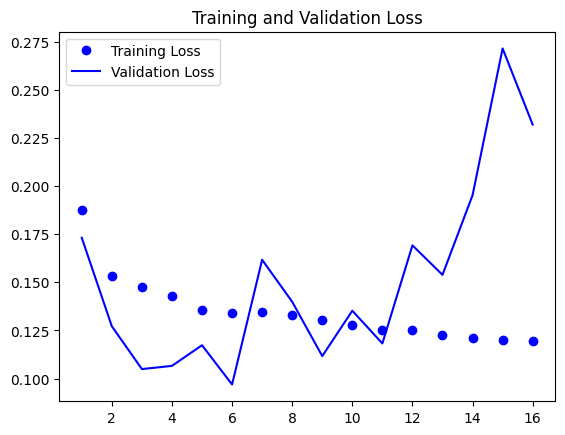

In [18]:
# plotting results
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

### Using Bidirectional RNNs

In [19]:
# generator yielding reversed timeseries samples an their targets
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size = 64, step=5):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                    i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
                    
        samples = np.zeros((len(rows), 
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets

In [20]:
# preparing the reversed training, validation, and test generators
lookback = 60
step = 5
delay = 1
batch_size = 64

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=4000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=4001,
                    max_index=4300,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay = delay,
                     min_index=4301,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (4300 - 4001 - lookback)

test_steps = (len(float_data) - 4301 - lookback)

In [21]:
# training and evaluating a dropout-regularized, stacked GRU model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.2,
                     recurrent_dropout=0.5,
                     input_shape=(None, float_data.shape[-1]),
                     return_sequences=True))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.2,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=128,
                    epochs=16,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/16
128/128 [==============================] - 8s 54ms/step - loss: 0.2648 - val_loss: 0.3290
Epoch 2/16
128/128 [==============================] - 7s 54ms/step - loss: 0.2146 - val_loss: 0.4202
Epoch 3/16
128/128 [==============================] - 7s 53ms/step - loss: 0.1955 - val_loss: 0.2934
Epoch 4/16
128/128 [==============================] - 7s 52ms/step - loss: 0.1884 - val_loss: 0.1578
Epoch 5/16
128/128 [==============================] - 7s 52ms/step - loss: 0.1775 - val_loss: 0.1679
Epoch 6/16
128/128 [==============================] - 7s 53ms/step - loss: 0.1700 - val_loss: 0.2092
Epoch 7/16
128/128 [==============================] - 7s 52ms/step - loss: 0.1612 - val_loss: 0.1420
Epoch 8/16
128/128 [==============================] - 7s 53ms/step - loss: 0.1552 - val_loss: 0.1543
Epoch 9/16
128/128 [==============================] - 7s 53ms/step - loss: 0.1482 - val_loss: 0.2078
Epoch 10/16
128/128 [==============================] - 7s 54ms/step - loss: 0.1424 - val_lo

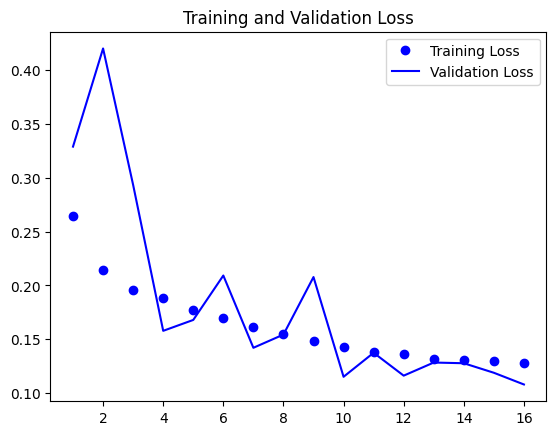

In [22]:
# plotting results
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [23]:
# training and evaluating an LSTM using reversed sequences
model = Sequential()
model.add(layers.LSTM(32, 
                     dropout=0.2,
                     recurrent_dropout=0.5,
                     input_shape=(None, float_data.shape[-1]),
                     return_sequences=True))
model.add(layers.LSTM(64, activation='relu',
                     dropout=0.2,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=128,
                    epochs=16,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/16
128/128 [==============================] - 9s 59ms/step - loss: 0.2222 - val_loss: 0.3515
Epoch 2/16
128/128 [==============================] - 7s 58ms/step - loss: 0.1924 - val_loss: 0.4438
Epoch 3/16
128/128 [==============================] - 7s 58ms/step - loss: 0.1846 - val_loss: 0.3499
Epoch 4/16
128/128 [==============================] - 7s 58ms/step - loss: 0.1781 - val_loss: 0.2162
Epoch 5/16
128/128 [==============================] - 7s 56ms/step - loss: 0.1675 - val_loss: 0.4057
Epoch 6/16
128/128 [==============================] - 7s 57ms/step - loss: 0.1613 - val_loss: 0.2567
Epoch 7/16
128/128 [==============================] - 7s 58ms/step - loss: 0.1596 - val_loss: 0.2077
Epoch 8/16
128/128 [==============================] - 8s 59ms/step - loss: 0.1531 - val_loss: 0.2355
Epoch 9/16
128/128 [==============================] - 7s 58ms/step - loss: 0.1502 - val_loss: 0.3879
Epoch 10/16
128/128 [==============================] - 7s 59ms/step - loss: 0.1458 - val_lo

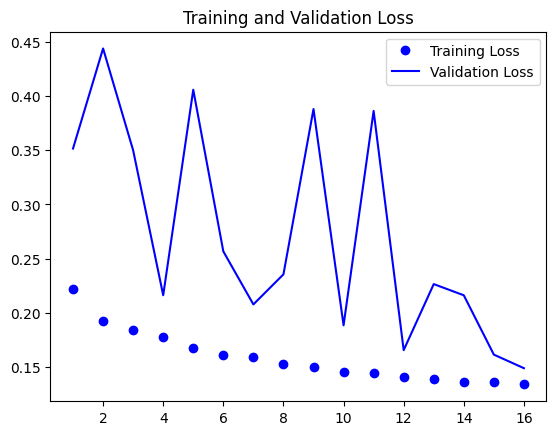

In [24]:
# plotting results
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [25]:
# training and evaluating a bidirectional LSTM
model = Sequential()
model.add(layers.Bidirectional(layers.LSTM(32, 
                                          dropout=0.2,
                                          recurrent_dropout=0.5,
                                          input_shape=(None, float_data.shape[-1]),
                                          return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(64, activation='relu',
                                          dropout=0.2,
                                          recurrent_dropout=0.5)))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=128,
                    epochs=16,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/16
128/128 [==============================] - 18s 115ms/step - loss: 0.1919 - val_loss: 0.4889
Epoch 2/16
128/128 [==============================] - 14s 110ms/step - loss: 0.1521 - val_loss: 0.4983
Epoch 3/16
128/128 [==============================] - 14s 110ms/step - loss: 0.1411 - val_loss: 0.2290
Epoch 4/16
128/128 [==============================] - 14s 109ms/step - loss: 0.1364 - val_loss: 0.2309
Epoch 5/16
128/128 [==============================] - 14s 109ms/step - loss: 0.1343 - val_loss: 0.2444
Epoch 6/16
128/128 [==============================] - 14s 110ms/step - loss: 0.1275 - val_loss: 0.1424
Epoch 7/16
128/128 [==============================] - 14s 111ms/step - loss: 0.1241 - val_loss: 0.1865
Epoch 8/16
128/128 [==============================] - 14s 110ms/step - loss: 0.1239 - val_loss: 0.1606
Epoch 9/16
128/128 [==============================] - 14s 111ms/step - loss: 0.1212 - val_loss: 0.2641
Epoch 10/16
128/128 [==============================] - 15s 115ms/step - l

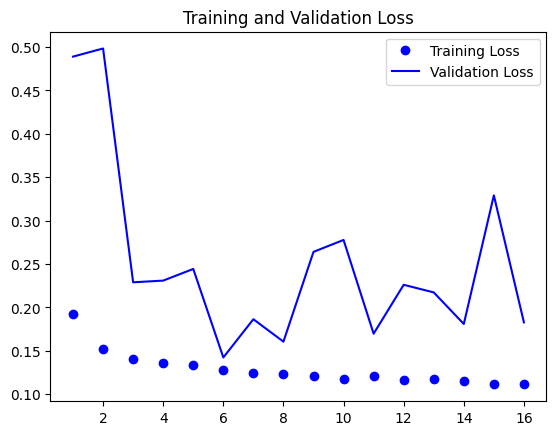

In [26]:
# plotting results
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [27]:
# training and evaluating a bidirectional GRU
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32, 
                                         dropout=0.2,
                                         recurrent_dropout=0.5,
                                         input_shape=(None, float_data.shape[-1]),
                                         return_sequences=True)))
model.add(layers.Bidirectional(layers.GRU(64, activation='relu',
                                         dropout=0.2,
                                         recurrent_dropout=0.5)))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=128,
                    epochs=16,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/16
128/128 [==============================] - 17s 109ms/step - loss: 0.1698 - val_loss: 0.1933
Epoch 2/16
128/128 [==============================] - 14s 109ms/step - loss: 0.1400 - val_loss: 0.1048
Epoch 3/16
128/128 [==============================] - 14s 107ms/step - loss: 0.1357 - val_loss: 0.1375
Epoch 4/16
128/128 [==============================] - 14s 106ms/step - loss: 0.1288 - val_loss: 0.1360
Epoch 5/16
128/128 [==============================] - 13s 105ms/step - loss: 0.1280 - val_loss: 0.1551
Epoch 6/16
128/128 [==============================] - 13s 105ms/step - loss: 0.1244 - val_loss: 0.1111
Epoch 7/16
128/128 [==============================] - 13s 105ms/step - loss: 0.1233 - val_loss: 0.1602
Epoch 8/16
128/128 [==============================] - 14s 106ms/step - loss: 0.1220 - val_loss: 0.1606
Epoch 9/16
128/128 [==============================] - 13s 105ms/step - loss: 0.1209 - val_loss: 0.2570
Epoch 10/16
128/128 [==============================] - 14s 106ms/step - l

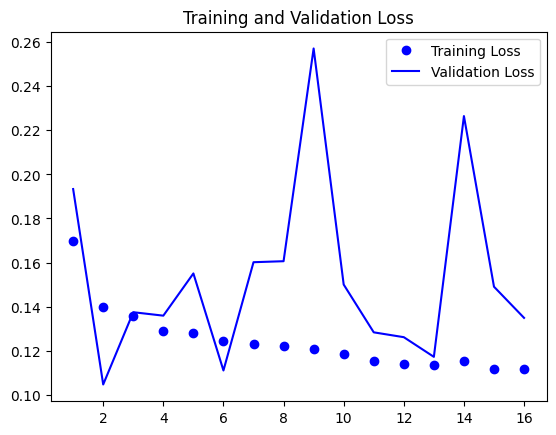

In [28]:
# plotting results
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()